In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time

In [2]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

#convolutional Layer 3
filter_size3 = 5
num_filter3 = 36

# Fully-connected layer.
fc_size1 = 300             # Number of neurons in fully-connected layer1.
fc_size2 = 300

# seed to make debugging easy
seed =165

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
#x_batch=data.train.images
#y_true_batch=data.train.labels

In [5]:
x_batch, y_true_batch = data.train.next_batch(1060000)

In [6]:
x_test,y_test_tru=data.test.next_batch(100000)

In [7]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

In [8]:
def new_weights(shape):
    return tf.Variable(tf.random_normal(shape,seed=seed))

In [9]:
def new_biases(length):
    return tf.Variable(tf.random_normal([length],seed=seed))

In [10]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights 

In [11]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat,num_features

In [13]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True,
                dropout=False,
                kep_prob=1): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)
    if dropout:
        layer = tf.nn.dropout(layer,kep_prob)

    return layer

In [14]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

In [15]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [16]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [17]:
kee_prob = tf.placeholder(tf.float32)

In [18]:
y_true_cls = tf.argmax(y_true, axis=1)

In [19]:
layer_conv1, weights_conv1 = new_conv_layer(input=x_image,num_input_channels=num_channels,filter_size=filter_size1,num_filters=num_filters1,use_pooling=True)

In [20]:
layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1,num_input_channels=num_filters1,filter_size=filter_size2,num_filters=num_filters2,use_pooling=True)

In [21]:
layer_flat, num_features = flatten_layer(layer_conv2)

In [22]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size1,
                         use_relu=True,
                         kep_prob=kee_prob,
                         dropout=True)
                    

In [23]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size1,
                         num_outputs=fc_size2,
                         use_relu=True,
                         kep_prob=kee_prob,
                         dropout=True)
                         
                       

In [24]:
layer_fc3 = new_fc_layer(input=layer_fc2,
                         num_inputs=fc_size2,
                         num_outputs=num_classes,
                         use_relu=False)

In [25]:
y_pred = tf.nn.softmax(layer_fc3)

In [26]:
y_pred_cls = tf.argmax(y_pred, axis=1)

In [27]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc3,
                                                        labels=y_true))

In [28]:
learning_rate=0.001

In [29]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [30]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [31]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [32]:
init = tf.global_variables_initializer()

save the model

In [33]:
saver = tf.train.Saver()

In [34]:
save_pat='temp/CNN/mnist_cnn.ckpt'

k

In [35]:
session = tf.Session()

In [36]:
session.run(init)

In [87]:
t=time.clock()
c_sum=0
for ju in xrange(3):
    for i in xrange(11000):
        huyt=x_batch[i*10:(i+1)*10-1]#sedwe[:,0:1],sedwe[:,1:]
        sdws=y_true_batch[i*10:(i+1)*10-1]
        _, c = session.run([optimizer,cost],feed_dict={x:huyt,y_true:sdws,kee_prob:0.8})
        c_sum+=c
        if (i+1)%1000==0:
            print "Round:",ju+1,"Batch:", i+1,"Cost:",c_sum/1000.0
            c_sum=0
print "\nTime took",time.clock()-t

Round: 1 Batch: 1000 Cost: 13.1813143978
Round: 1 Batch: 2000 Cost: 22.6306515198
Round: 1 Batch: 3000 Cost: 20.4824664726
Round: 1 Batch: 4000 Cost: 16.1547400627
Round: 1 Batch: 5000 Cost: 18.4467620544
Round: 1 Batch: 6000 Cost: 15.6925638542
Round: 1 Batch: 7000 Cost: 18.6268839396
Round: 1 Batch: 8000 Cost: 22.3060575909
Round: 1 Batch: 9000 Cost: 17.1608014699
Round: 1 Batch: 10000 Cost: 19.1481070175
Round: 1 Batch: 11000 Cost: 17.2374863567
Round: 2 Batch: 1000 Cost: 16.2271739988
Round: 2 Batch: 2000 Cost: 16.825999427
Round: 2 Batch: 3000 Cost: 17.2356368732
Round: 2 Batch: 4000 Cost: 18.1712877998
Round: 2 Batch: 5000 Cost: 23.8690185223
Round: 2 Batch: 6000 Cost: 14.0931378925
Round: 2 Batch: 7000 Cost: 21.4331400897
Round: 2 Batch: 8000 Cost: 18.0033720546
Round: 2 Batch: 9000 Cost: 16.9109003363
Round: 2 Batch: 10000 Cost: 8.49187057588
Round: 2 Batch: 11000 Cost: 20.0719099445
Round: 3 Batch: 1000 Cost: 17.3217916958
Round: 3 Batch: 2000 Cost: 19.622526675
Round: 3 Batch

In [88]:
t=time.clock()
j=0
print 67
kd_no=[]
#predict = (, 1)
#test_x=np.array(test.loc[:])
for i in xrange(20000):
    pred = session.run(y_pred_cls,{x:x_test[i:i+1],kee_prob:1.0})
    if pred == np.argmax(y_test_tru[i]):
        j+=1
    else:
        kd_no.append(i)
        

print "Time took",time.clock()-t,'\nAccuracy:',j*100.0/20000,"%"

67
Time took 88.687533 
Accuracy: 98.34 %


In [37]:
t=time.clock()
j=0
print 67
kd_no=[]
#predict = (, 1)
#test_x=np.array(test.loc[:])
for i in xrange(20000):
    pred = session.run(y_pred_cls,{x:x_test[i:i+1],kee_prob:1.0})
    if pred == np.argmax(y_test_tru[i]):
        j+=1
    else:
        kd_no.append(i)
        

print "Time took",time.clock()-t,'\nAccuracy:',j*100.0/20000,"%"

67
Time took 106.705189 
Accuracy: 98.26 %


In [38]:
j,20000-j

(19652, 348)

pred: [0] 
true: 0
0.007801


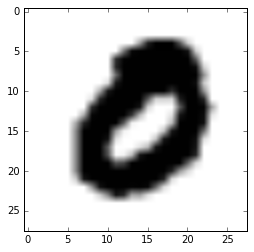

In [40]:
t=time.clock()
shap=[28,28]
#i=kd_no[280]
i=25
print 'pred:',session.run(y_pred_cls,{x:x_test[i:i+1],kee_prob:1.0}),'\ntrue:',np.argmax(y_test_tru[i])
print time.clock()-t
plt.imshow(x_test[i].reshape(shap),cmap='binary')
#print time.clock()-t

## save the best model

d

In [75]:
saver.save(sess=session,save_path=save_pat)

'temp/CNN/mnist_cnn.ckpt'

## restore the model

In [37]:
saver.restore(sess=session,save_path=save_pat)

INFO:tensorflow:Restoring parameters from temp/CNN/mnist_cnn.ckpt


In [46]:
vars_in_checkpoint = tf.train.list_variables(save_pat)

In [47]:
vars_in_checkpoint

[('Variable', [5, 5, 1, 16]),
 ('Variable/Adam', [5, 5, 1, 16]),
 ('Variable/Adam_1', [5, 5, 1, 16]),
 ('Variable_1', [16]),
 ('Variable_1/Adam', [16]),
 ('Variable_1/Adam_1', [16]),
 ('Variable_2', [5, 5, 16, 36]),
 ('Variable_2/Adam', [5, 5, 16, 36]),
 ('Variable_2/Adam_1', [5, 5, 16, 36]),
 ('Variable_3', [36]),
 ('Variable_3/Adam', [36]),
 ('Variable_3/Adam_1', [36]),
 ('Variable_4', [1764, 300]),
 ('Variable_4/Adam', [1764, 300]),
 ('Variable_4/Adam_1', [1764, 300]),
 ('Variable_5', [300]),
 ('Variable_5/Adam', [300]),
 ('Variable_5/Adam_1', [300]),
 ('Variable_6', [300, 300]),
 ('Variable_6/Adam', [300, 300]),
 ('Variable_6/Adam_1', [300, 300]),
 ('Variable_7', [300]),
 ('Variable_7/Adam', [300]),
 ('Variable_7/Adam_1', [300]),
 ('Variable_8', [300, 10]),
 ('Variable_8/Adam', [300, 10]),
 ('Variable_8/Adam_1', [300, 10]),
 ('Variable_9', [10]),
 ('Variable_9/Adam', [10]),
 ('Variable_9/Adam_1', [10]),
 ('beta1_power', []),
 ('beta2_power', [])]